#### Image input 

In [6]:
from openai import OpenAI
from dotenv import load_dotenv
from scipy.ndimage import gaussian_filter
from itertools import product
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import base64
import numpy as np
from scipy.stats import norm
from scipy.interpolate import make_interp_spline
import os
import cv2

##### General settings, parameters and utility functions

In [ ]:
# Setup LLM 
# Load environment variables
load_dotenv()
# Initialize OpenAI client
client = OpenAI()
model = "gpt-4o"

images_dir_nodistractor = "tilt_illusion_images_nodistractor"
images_dir_distractor_contrast = "tilt_illusion_images_distractor_contrast"
images_dir_distractor_depth = "tilt_illusion_images_distractor_depth"

report_nodistractor = "responses_nodistractor.csv"
report_distractor_contrast = "responses_distractor_contrast.csv"
report_distractor_depth = "responses_distractor_depth.csv"

report_nodistractor_context = "responses_nodistractor_context.csv"
report_distractor_contrast_context = "responses_distractor_contrast_context.csv"
report_distractor_depth_context = "responses_distractor_depth_context.csv"

responses_dir = "tilt_illusion_responses"

def encode_image(image_path):
    """Encodes an image to base64 format."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
    
def save_file(file_name, data, header):  
    """Saves the data to a CSV file."""
    file_path = os.path.join(responses_dir, file_name)  
    with open(file_path, mode="w", newline="") as file_path:
        writer = csv.writer(file_path)
        writer.writerow(header) 
        writer.writerows(data)

    print(f"Responses saved to '{file_name}' successfully!")

def extract_info_image(image_name):
    """Extracts angle, cntr_center, cntr_back, and s from the image name."""
    # Regular expression to extract the values
    pattern = r"angle(-?\d+)_cntr_center(?P<center>[-+]?\d*\.?\d+)_cntr_back(?P<back>[-+]?\d*\.?\d+)_s_(yes|no)_.png"
    angle, cntr_center, cntr_back, s = None, None, None, None
    match = re.match(pattern, image_name)

    if match:
        # Extract values
        angle = int(match.group(1)) 
        cntr_center = float(match.group(2))  
        cntr_back = float(match.group(3))  
        s = match.group(4) 

    return angle, cntr_center, cntr_back, s

def read_csv(file_name):
    """Reads a CSV file and returns a DataFrame."""
    file_path = os.path.join(responses_dir, file_name)  
    df = pd.read_csv(file_path)
    return df

##### Functions to generate and save tilt images

In [4]:
def adjust_contrast(image, contrast):
    """
    Adjust the contrast of a grayscale image.
    contrast: float (0 to 1) - Lower values reduce contrast, higher values increase contrast.
    """
    image = (image - 0.5) * contrast + 0.5
    return np.clip(image, 0, 1)

def add_circle_shadow(image, center_radius, shadow_intensity, shadow_blur, shadow_color=0.1):
    """
    Add a natural gray shadow around the center circle.
    shadow_intensity: float (0 to 1) - Darkness of the shadow.
    shadow_blur: int - Amount of blur to make the shadow soft.
    shadow_color: float (0 to 1) - Gray color intensity (0: black, 1: white).
    """
    size = image.shape[0]
    x = np.linspace(-size/2, size/2, size)
    y = np.linspace(-size/2, size/2, size)
    X, Y = np.meshgrid(x, y)
    
    # Calculate the distance from the center
    distance = np.sqrt(X**2 + Y**2)
    
    # Create a soft shadow ring around the circle
    shadow = np.clip((distance - center_radius) / shadow_blur, 0, 1) * shadow_intensity
    shadow = gaussian_filter(shadow, sigma=shadow_blur)

    # Apply the gray shadow to the ring area by blending with the shadow color
    shadow_mask = (distance > center_radius) & (distance < center_radius + shadow_blur * 2)
    image[shadow_mask] = (1 - shadow[shadow_mask]) * image[shadow_mask] + shadow[shadow_mask] * shadow_color
    return image

def save_image(image, file_name, size):
    """Save the image to a file.
    image: np.ndarray - The image to save.
    file_name: str - The name of the file to save.
    size: int - The size of the image.
    """
    # Plot the illusion
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray', extent=(-size/2, size/2, -size/2, size/2), vmin=0, vmax=1)
    plt.axis('off')
  
    # Save the image
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    plt.close()


def generate_tilt_illusion_images(angle_center, angle_background, width_lines_center, width_lines_back, contrast_center, contrast_background, shadow_intensity, shadow_blur, file_name):
    """Generate the tilt illusion image with specified parameters. 
    angle_center: float - Angle of the center circle.
    angle_background: float - Angle of the background stripes.
    width_lines_center: float - Depth of the center circle stripes.
    width_lines_back: float - Depth of the background stripes.
    contrast_center: float - Contrast of the center circle.
    contrast_background: float - Contrast of the background stripes.
    shadow_intensity: float - Intensity of the shadow around the center circle.
    shadow_blur: float - Blur amount for the shadow.
    file_name: str - Name of the output image file.
    """
    
    # Image size and circle parameters
    size = 320
    center_radius = 60
    external_radius = 160
    
    # Create coordinate grid
    x = np.linspace(-size/2, size/2, size)
    y = np.linspace(-size/2, size/2, size)
    X, Y = np.meshgrid(x, y)

    # Calculate the angle in radians
    angle_center_rad = np.radians(angle_center)
    angle_background_rad = np.radians(angle_background)
    
    # Create stripe patterns
    center_pattern = np.sin((X * np.cos(angle_center_rad) + Y * np.sin(angle_center_rad)) / width_lines_center)
    background_pattern = np.sin((X * np.cos(angle_background_rad) + Y * np.sin(angle_background_rad)) / width_lines_back)

    # Normalize patterns to [0, 1] for grayscale
    center_pattern = (center_pattern + 1) / 2 + 0.01
    background_pattern = (background_pattern + 1) / 2 + 0.01
   
    # Apply contrast adjustment to both patterns   
    center_pattern = adjust_contrast(center_pattern, contrast_center)               
    background_pattern = adjust_contrast(background_pattern, contrast_background)      
   
    # Create a circular mask for the external circle
    circle_out_mask = (X**2 + Y**2) < external_radius**2

    # Create a circular mask for the center
    circle_mask = (X**2 + Y**2) < center_radius**2

    # Combine center and background patterns
    illusion_image = 1 * np.ones((size, size))  
    illusion_image[circle_out_mask] = background_pattern[circle_out_mask]
    illusion_image[circle_mask] = center_pattern[circle_mask] 

    # Add depth shadow around the center circle
    illusion_image = add_circle_shadow(illusion_image, center_radius, shadow_intensity, shadow_blur)
    
    save_image(illusion_image, file_name, size)

    

##### Create tilt images with differenter parameters

In [ ]:

def generate_image_set(images_dir, angle_background_list, contrast_center_list, contrast_background_list, shadow_list):
    """Generate images using combinations of parameters"""
    width_lines_center = 5
    width_lines_back = 5

    for ab, cc, cb, s in product(angle_background_list, contrast_center_list, contrast_background_list, shadow_list):
        file_name = f"angle{ab}_cntr_center{cc}_cntr_back{cb}_s_{s}_.png"
        file_path = os.path.join(images_dir, file_name)
        if s == 'yes':
            shadow_intensity = 0.7
            shadow_blur = 2.5
        else:
            shadow_intensity = 0
            shadow_blur = 0.000001

        generate_tilt_illusion_images(0, ab, width_lines_center, width_lines_back, cc, cb, shadow_intensity, shadow_blur, file_path)

    # generate control image no distractor
    file_name = "angle0_cntr_center0_cntr_back0_s_control_.png"
    file_path = os.path.join(images_dir, file_name)
    generate_tilt_illusion_images(0, 0, width_lines_center, 0, 1, 0, 0, 0.000001, file_path)


# Set No distractor
angle_background_list = [-90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90] 
contrast_center_list = [1]
contrast_background_list = [1]
shadow_list = ['no']

generate_image_set(images_dir_nodistractor, angle_background_list, contrast_center_list, contrast_background_list, shadow_list)

# Set distractor contrast
angle_background_list = [-90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90] 
contrast_center_list = [1]
contrast_background_list = [0.4]
shadow_list = ['no']

generate_image_set(images_dir_distractor_contrast, angle_background_list, contrast_center_list, contrast_background_list, shadow_list)

# Set distractor Depth Difference
angle_background_list = [-90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90] 
contrast_center_list = [1]
contrast_background_list = [1]
shadow_list = ['yes']

generate_image_set(images_dir_distractor_depth, angle_background_list, contrast_center_list, contrast_background_list, shadow_list)


# Test only one image
""" angle_background_list = [10, 50]
contrast_center_list = [0.2]
contrast_background_list = [0.2]
shadow_list = ['no']
 """




##### List of questions to ask to LLM

In [1]:

questions = [

  {'Topic': 'Orientation', 'Question': 'What is the orientation of the lines in the center circle of the image, is the orientation of the central anticlockwise or clockwise. Respond only with the orientation of the lines.'},
   
]


##### Functions to request prompts to LLMs with and without system context

In [ ]:

def question_tilt_illusion(prompt_question, tilt_encoded_image):
    """Make the API request to get the response for the tilt illusion without context."""
    response = client.chat.completions.create(
        model=model,
        temperature=0.2,  # Less creative, more focused on the task
        top_p=1, 
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_question},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{tilt_encoded_image}",
                        },
                    },
                ],
            }
        ],
    )
    return response

def question_tilt_illusion_more_context(prompt_question, tilt_encoded_image):
    """Make the API request to get the response for the tilt illusion with more context."""
    response = client.chat.completions.create(
        model=model,
        temperature=0.2,  # Less creative, more focused on the task
        top_p=1, 
        messages=[
            {
                "role": "system",  # Define system-level instructions for context
                "content": "This image represents a tilt illusion, featuring concentric circles with varying orientations and tilts. The visual arrangement aims to demonstrate how the perceived orientation of the central elements can be influenced by the surrounding context, creating the illusion of repulsion or attraction between the orientations."
                
                    
                
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_question},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{tilt_encoded_image}",
                        },
                    },
                ],
            }
        ],
    )

    return response



##### Ask to LLM for each of the images to analyze

In [ ]:
def request_llm_examine_images(images_dir, questions, file_name, type_prompt = 1):
    """Interative process to request the LLM to analyze images dataset and save the responses in report."""
    responses_data = []
    header_row = ['Image', 'Angle', 'Contrast center 1 = None' , 'Contrast sorrounding 1 = None', 'Depth Difference', 'Response', 'Response_adjusted', 'Clockwise', 'Counterclockwise', 'Vertical']
    
    for i in range(10):
        for filename in os.listdir(images_dir):
            if filename.endswith(".png"):
                counterclockwise = 0
                clockwise = 0
                vertical = 0
                response_adjusted = ""
                # Read the image
                image_path = os.path.join(images_dir, filename)
                image = cv2.imread(image_path)
                angle, cntr_center, cntr_back, s = extract_info_image(filename)
                
                tilt_encoded_image = encode_image(image_path)
                print(f"\nEncoded image for {filename}")
         
                for question in questions:
                    prompt_question = question['Question']

                    if type_prompt == 1:
                        response = question_tilt_illusion(str(prompt_question), tilt_encoded_image)
                    if type_prompt == 2:
                        response = question_tilt_illusion_more_context(str(prompt_question), tilt_encoded_image)

                    response_llm = response.choices[0].message.content 
                    print(f"\n{prompt_question}: {response_llm}")         

                    # Colect the response and normalize it for the report                   
            
                    if "counterclockwise" in response_llm.lower() or "anticlockwise" in response_llm.lower():
                        counterclockwise = 1
                        response_adjusted = "anticlockwise"
                    elif "clockwise" in response_llm.lower():
                        clockwise = 1
                        response_adjusted = "clockwise" 
                    elif "vertical" or "vertically" in response_llm.lower():
                        vertical = 1  
                        response_adjusted = "vertical"
                    else:
                        response_adjusted = "None"

                    responses_data.append([filename, angle, cntr_center, cntr_back, s, response_llm, response_adjusted, clockwise, counterclockwise, vertical])
                  
                    
    save_file(file_name, responses_data, header_row)


                        

#### Run the image analyzes without context

In [ ]:
# Call the function without context for the three group of images 
request_llm_examine_images(images_dir_nodistractor, questions, report_nodistractor, 1)
request_llm_examine_images(images_dir_distractor_contrast, questions, report_distractor_contrast, 1)
request_llm_examine_images(images_dir_distractor_depth, questions, report_distractor_depth, 1)



Encoded image for angle-10_cntr_center1_cntr_back1_s_yes_.png

What is the orientation of the lines in the center circle of the image, is the orientation of the central anticlockwise or clockwise. Respond only with the orientation of the lines.: Clockwise.

Encoded image for angle-15_cntr_center1_cntr_back1_s_yes_.png

What is the orientation of the lines in the center circle of the image, is the orientation of the central anticlockwise or clockwise. Respond only with the orientation of the lines.: Clockwise.

Encoded image for angle-20_cntr_center1_cntr_back1_s_yes_.png

What is the orientation of the lines in the center circle of the image, is the orientation of the central anticlockwise or clockwise. Respond only with the orientation of the lines.: Clockwise.

Encoded image for angle-25_cntr_center1_cntr_back1_s_yes_.png

What is the orientation of the lines in the center circle of the image, is the orientation of the central anticlockwise or clockwise. Respond only with the orient

#### Run the image analyzes with context

In [ ]:
# Call the function with context for the three group of images 
request_llm_examine_images(images_dir_nodistractor, questions, report_nodistractor_context, 2)
request_llm_examine_images(images_dir_distractor_contrast, questions, report_distractor_contrast_context, 2)
request_llm_examine_images(images_dir_distractor_depth, questions, report_distractor_depth_context, 2)


Encoded image for angle-10_cntr_center1_cntr_back0.4_s_no_.png

What is the orientation of the lines in the center circle of the image, is the orientation of the central anticlockwise or clockwise. Respond only with the orientation of the lines.: Clockwise.

Encoded image for angle-15_cntr_center1_cntr_back0.4_s_no_.png

What is the orientation of the lines in the center circle of the image, is the orientation of the central anticlockwise or clockwise. Respond only with the orientation of the lines.: Clockwise.

Encoded image for angle-20_cntr_center1_cntr_back0.4_s_no_.png

What is the orientation of the lines in the center circle of the image, is the orientation of the central anticlockwise or clockwise. Respond only with the orientation of the lines.: Clockwise.

Encoded image for angle-25_cntr_center1_cntr_back0.4_s_no_.png

What is the orientation of the lines in the center circle of the image, is the orientation of the central anticlockwise or clockwise. Respond only with the or

#### Plot functions 

In [ ]:
def plot_frequency_report(data, title, filter): 
    """Plot the frequency of responses for each angle."""  
    data = data.dropna()
    filtered_data = data[data['Response_adjusted'] == filter]

    # Calculate the total responses for each angle
    total_responses_per_angle = data.groupby('Angle').size().sort_index()


    # Calculate the frequency of 'Counterclockwise' responses for each angle
    filtered_frequency = filtered_data.groupby('Angle').size()

    # Calculate the percentage frequency
    percentage = (filtered_frequency / total_responses_per_angle) * 100

    # Fit a standard normal distribution to the frequency data
    angles = percentage.index
    frequencies = percentage.values
    

    frequencies_filled = pd.Series(frequencies).interpolate().fillna(0)

    # Fit a polynomial trend curve 
    if len(angles) >= 8:
        degree = 8
        coefficients = np.polyfit(angles, frequencies_filled, degree)  # Fit a polynomial to the data
        x_smooth = np.linspace(angles.min(), angles.max(), 500)  # Generate smooth x values
        trend_curve_smooth = np.polyval(coefficients, x_smooth)  # Trend curve for smooth x
    else:
        x_smooth, trend_curve_smooth = angles, frequencies_filled

    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.plot(angles, frequencies, 'o', label="Observed Data")
    plt.plot(angles, frequencies_filled, label="Observed Data")   
    plt.plot(x_smooth, trend_curve_smooth, label="Trend Curve", color="green", linestyle='--')
    plt.minorticks_on()  # Add minor ticks to the grid

    plt.title("Percentage of "+ filter + " responses vs. Angle" + title)
    plt.xlabel("Angle")
    plt.ylabel("Percentage Frequency (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_df_line(data, filter):
    """Calculate the CDF line for the given data and filter."""
    data = data.dropna()
    data_filter = data[data["Response_adjusted"] == filter]    

    # Calculate the total sum of counts
    total_count = len(data_filter)
    
    # Group by angle and count clockwise responses at each angle
    angle_counts = data_filter.groupby("Angle").size().sort_index() 

    # Compute cumulative sum over angles
    cdf_counts = angle_counts.cumsum()

    cdf_calculation = (angle_counts / total_count)  # Calculate the probability density function (PDF)

    # Calculate min and max values
    min_value = cdf_calculation.min()
    max_value = cdf_calculation.max()

    # Normalize data to range [0, 1]
    cdf_calculation_norm = (cdf_calculation - min_value) / (max_value - min_value)
    # Normalize to get cumulative probability (CDF)
    cdf = cdf_counts / cdf_counts.iloc[-1]  # total clockwise responses    

    # Smooth the curve using spline interpolation (if more than 2 points)
    angles = cdf.index.values
    values = cdf.values

    # Smooth the curve using spline interpolation (if more than 2 points)
    angles_calc = cdf_calculation_norm.index.values
    values_calc = cdf_calculation_norm.values

    if len(angles) >= 5:
        x_smooth = np.linspace(angles.min(), angles.max(), 300)
        spline = make_interp_spline(angles, values, k=4)
        y_smooth = spline(x_smooth)
    else:
        x_smooth, y_smooth = angles, values

    return x_smooth, y_smooth, angles_calc, values_calc

def plot_cdf(df, title):   
    """Plot the CDF for clockwise and anticlockwise responses."""    
    x_smooth_cw, y_smooth_cw, x_smooth_cw_calc, y_smooth_cw_calc = calculate_df_line(df, "clockwise")
    x_smooth_acw, y_smooth_acw, x_smooth_acw_calc, y_smooth_acw_calc = calculate_df_line(df, "anticlockwise")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_smooth_cw, y_smooth_cw, label="Clockwise CDF", color='blue')
    plt.plot(x_smooth_acw, y_smooth_acw, label="Anticlockwise CDF", color='red')
    #plt.plot(x_smooth_cw_calc, y_smooth_cw_calc, label="CDF calc Clockwise", color='red')
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Cumulative probability responses")
    plt.title("CDF responses by angle" + title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cdf_consolidated(df_nodistractor, df_distractor_contrast, df_distractor_depth):   
    """Plot the CDF for clockwise and anticlockwise responses for all the grupo of images."""    
    x_smooth_cw_nodistractor, y_smooth_cw_nodistractor, x_smooth_cw_calc_nodistractor, y_smooth_cw_calc_nodistractor = calculate_df_line(df_nodistractor, "clockwise")
    x_smooth_cw_d1, y_smooth_cw_d1, x_smooth_cw_calc_d1, y_smooth_cw_calc_d1 = calculate_df_line(df_distractor_contrast, "clockwise")
    x_smooth_cw_d2, y_smooth_cw_d2, x_smooth_cw_calc_d2, y_smooth_cw_calc_d2 = calculate_df_line(df_distractor_depth, "clockwise")
    
    colors = ['#66b3ff', '#1f77b4', '#004c99']
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_smooth_cw_nodistractor, y_smooth_cw_nodistractor, label="No Distractor", color=colors[0])
    plt.plot(x_smooth_cw_d1, y_smooth_cw_d1, label="Distractor - Contrast", color=colors[1])
    plt.plot(x_smooth_cw_d2, y_smooth_cw_d2, label="Distractor - Depth Difference",color=colors[2])
    #plt.plot(x_smooth_cw_calc, y_smooth_cw_calc, label="CDF calc Clockwise", color='red')
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Cumulative probability responses")
    plt.title("Comparison CDF responses by angle - Clockwise")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_tables(df, title):
    """Plot the report in tabular format"""
    dfhead = df.head()
    # Create a matplotlib figure
    fig, ax = plt.subplots()

    # Hide axes
    ax.axis('tight')
    ax.axis('off')

    # Plot the table
    table = ax.table(cellText=dfhead.values, colLabels=dfhead.columns, loc='center')

    # Adjust table properties
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(5, 2)

    # Show the table
    plt.show()

    # Create a crosstab for 'Response_adjusted'
    crosstab = df['Response_adjusted'].value_counts(normalize=True) * 100
    
    # Plot the cross table as a bar chart
    crosstab.plot(kind='bar', figsize=(5, 4), legend=False, color=['skyblue', 'green', 'orange'])
    plt.title('Response Distribution' + title)
    plt.ylabel('Percentage')
    plt.xlabel('Response Adjusted')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


#### Plot graphs for responses without context

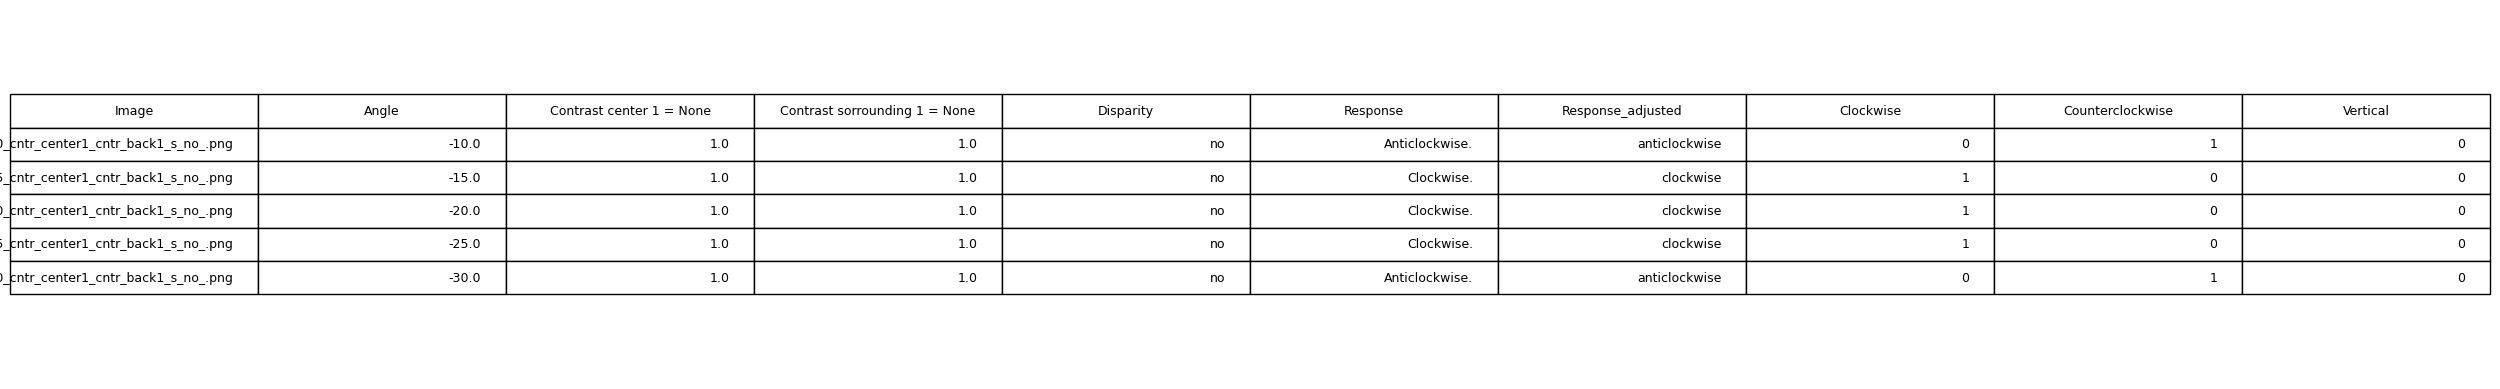

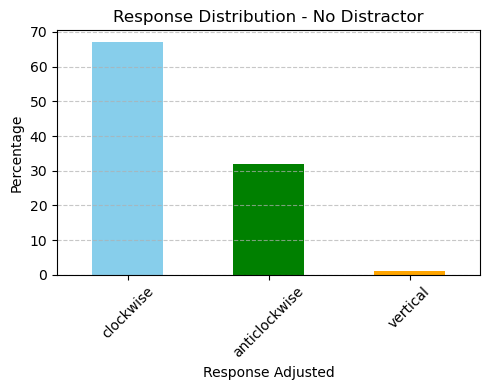

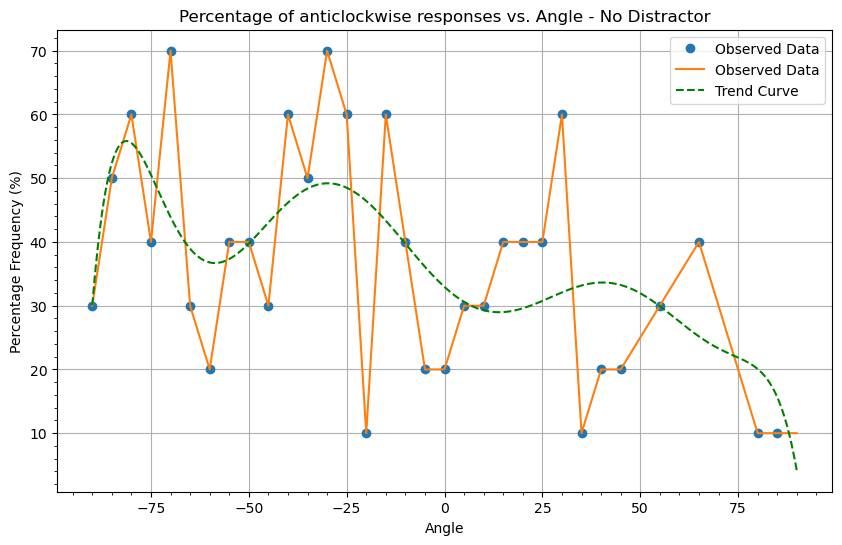

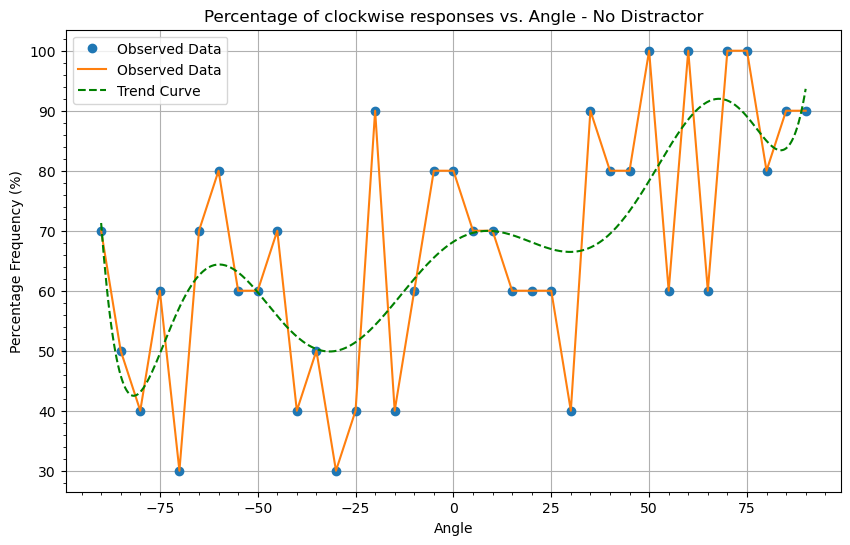

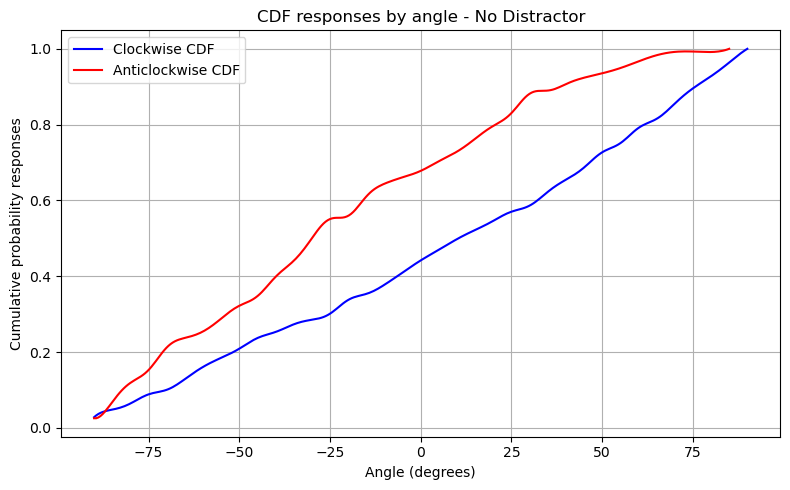

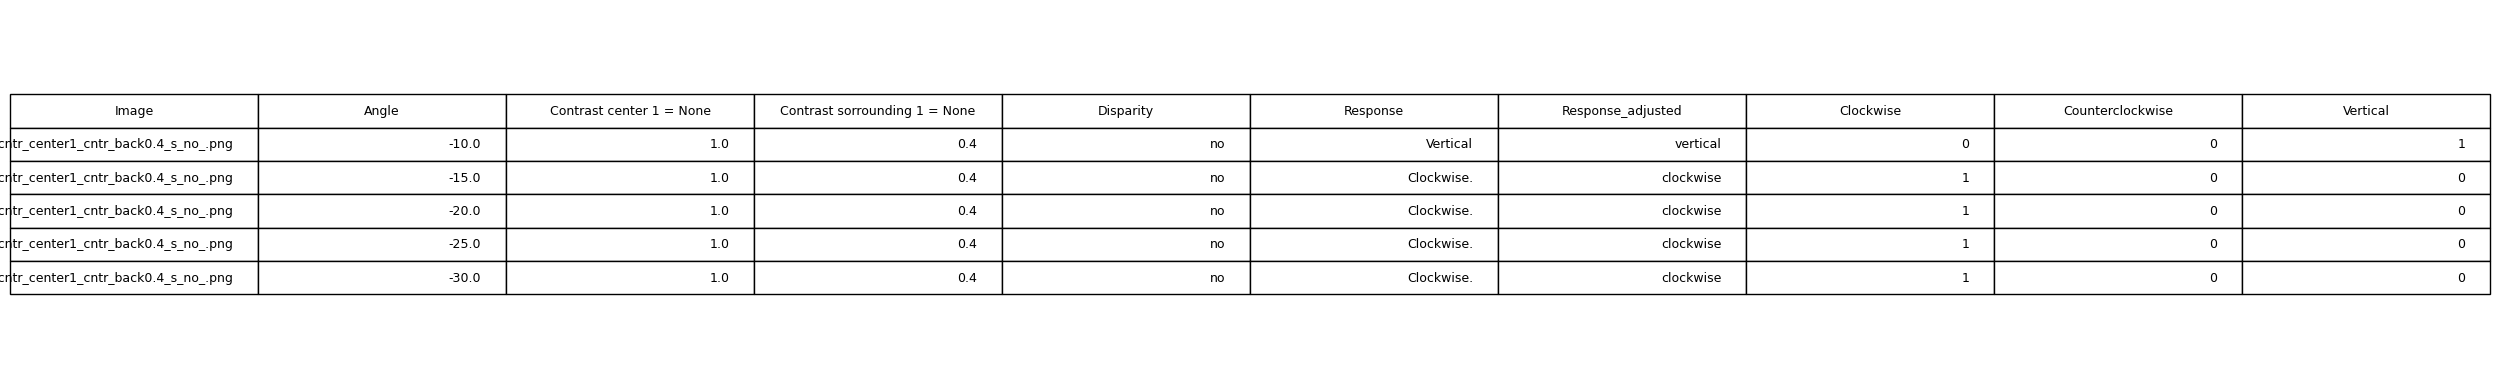

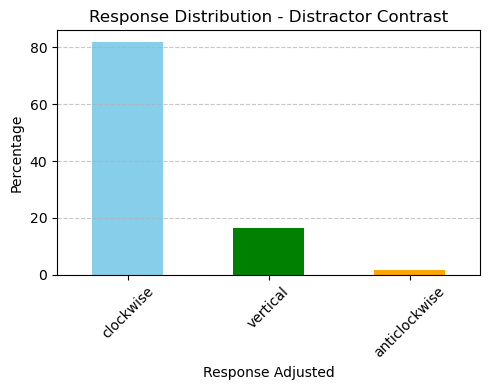

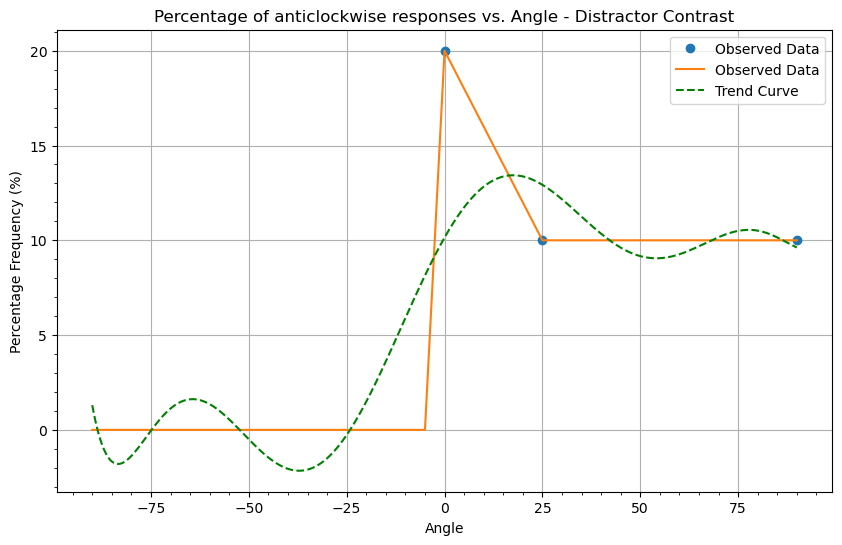

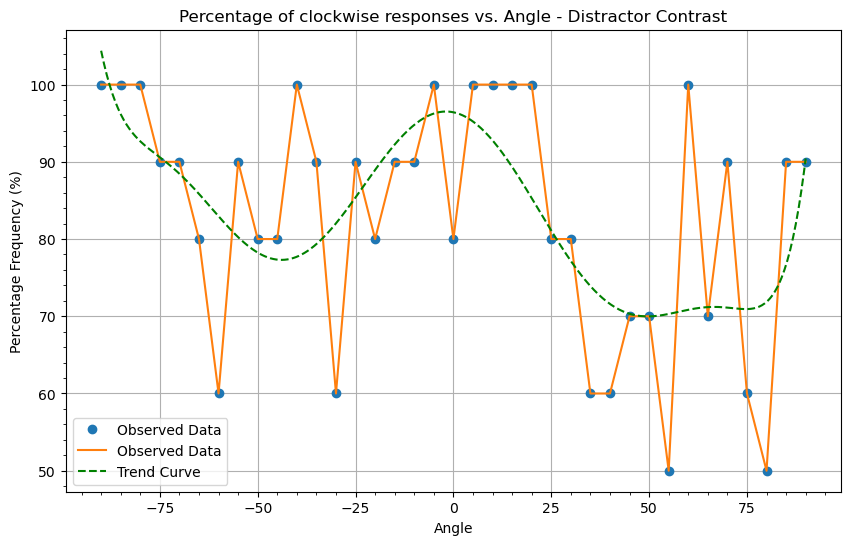

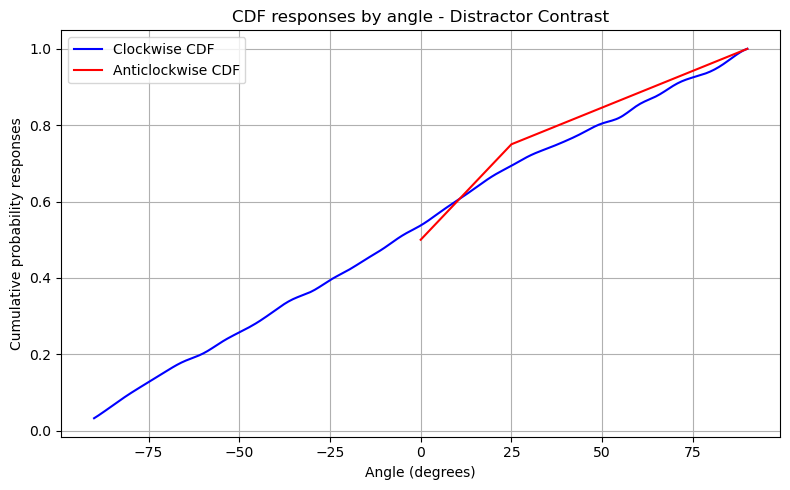

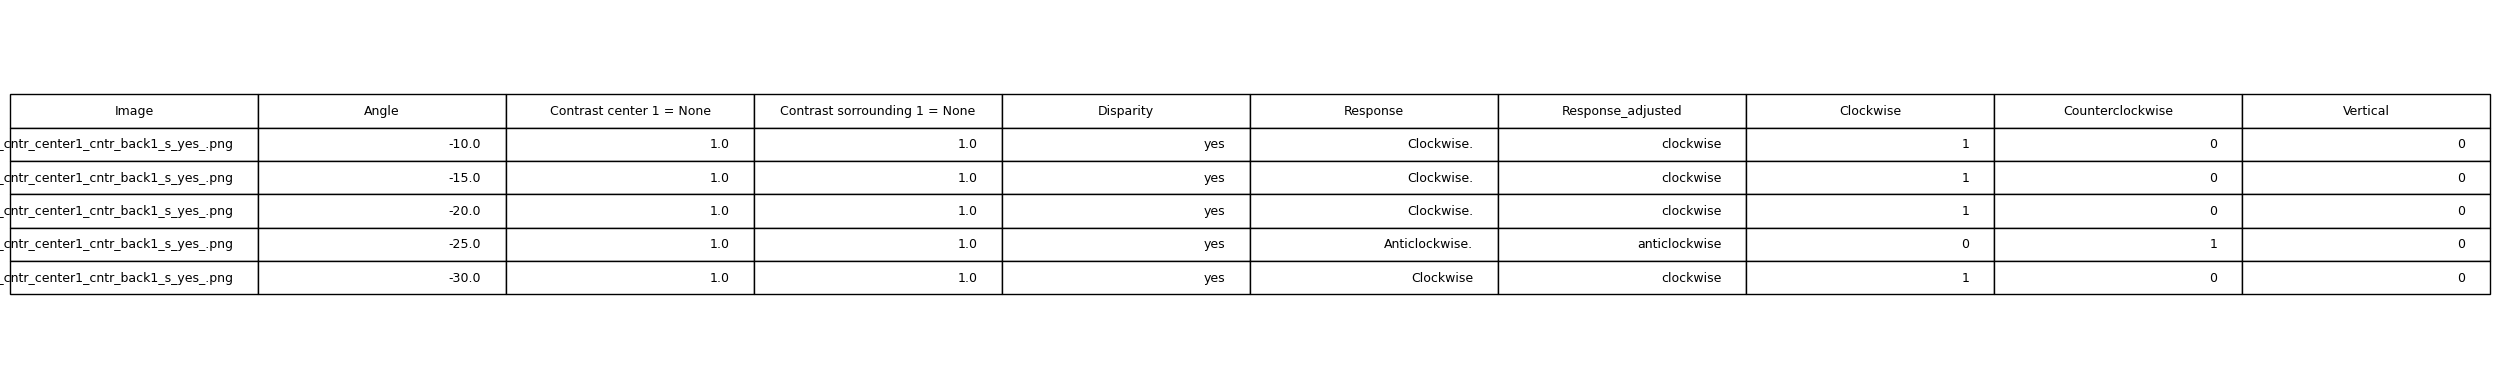

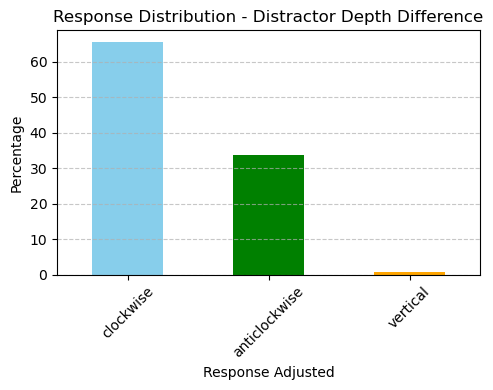

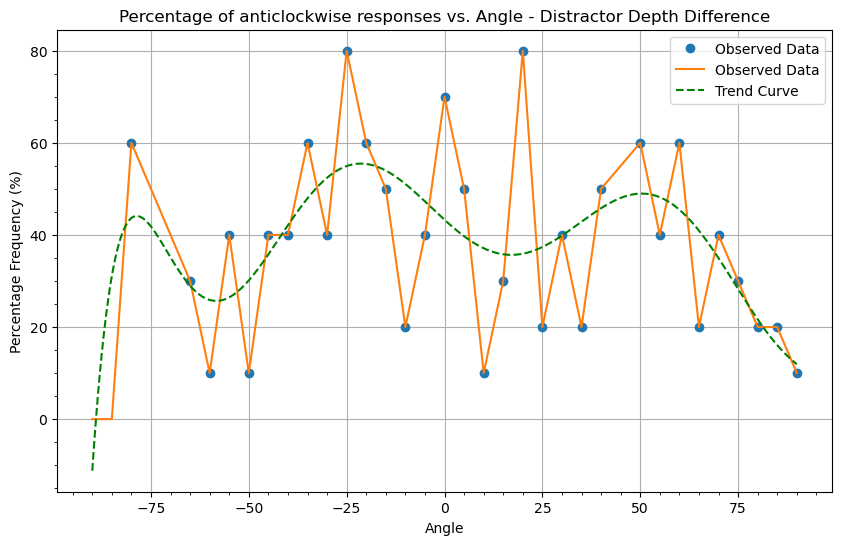

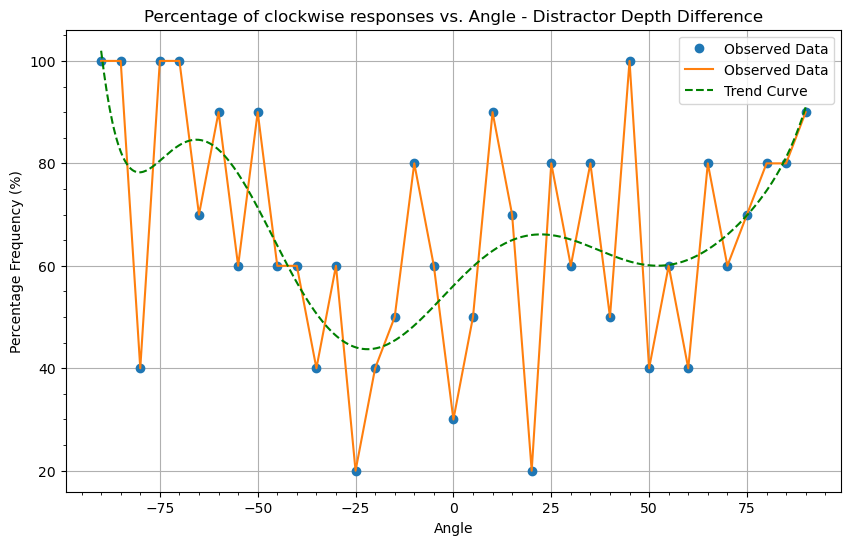

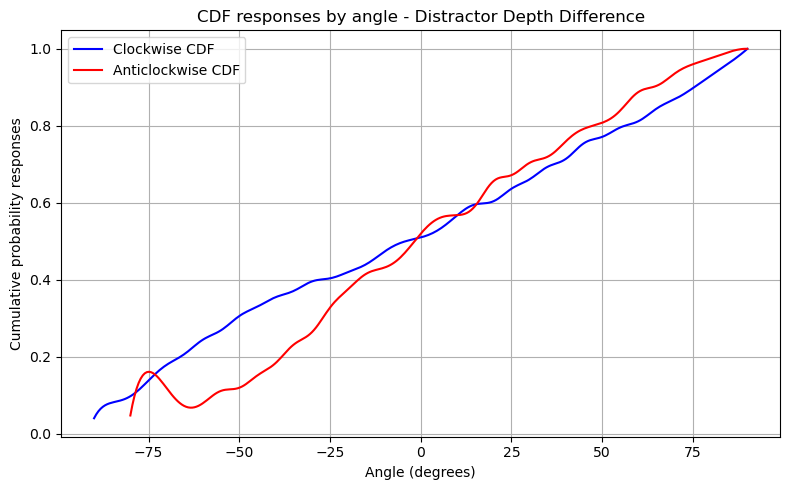

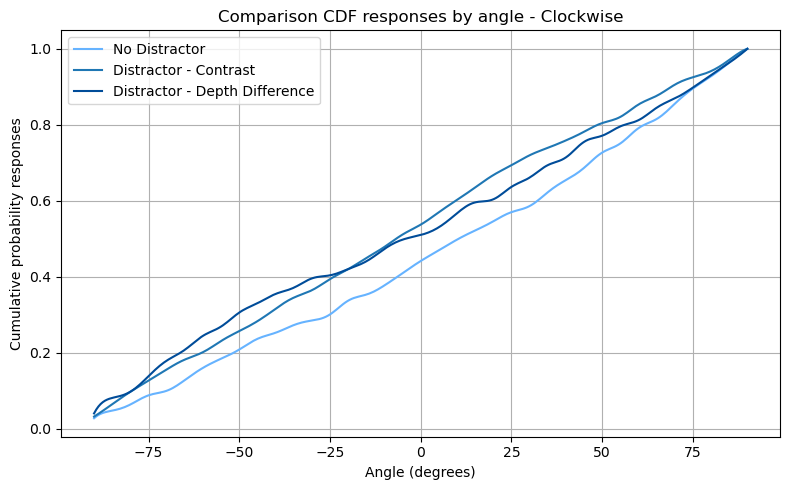

In [ ]:
# Call the function to plot the report for each group of images wiht and without context
data_nodistractor = read_csv(report_nodistractor)
plot_tables(data_nodistractor, " - No Distractor")
plot_frequency_report(data_nodistractor, " - No Distractor", "anticlockwise")
plot_frequency_report(data_nodistractor, " - No Distractor", "clockwise")
plot_cdf(data_nodistractor, " - No Distractor")


data_distractor_contrast = read_csv(report_distractor_contrast)
plot_tables(data_distractor_contrast, " - Distractor Contrast")
plot_frequency_report(data_distractor_contrast, " - Distractor Contrast", "anticlockwise")
plot_frequency_report(data_distractor_contrast, " - Distractor Contrast", "clockwise")
plot_cdf(data_distractor_contrast, " - Distractor Contrast")


data_distractor_depth = read_csv(report_distractor_depth)
plot_tables(data_distractor_depth, " - Distractor Depth Difference")
plot_frequency_report(data_distractor_depth, " - Distractor Depth Difference", "anticlockwise")
plot_frequency_report(data_distractor_depth, " - Distractor Depth Difference", "clockwise")
plot_cdf(data_distractor_depth, " - Distractor Depth Difference")

plot_cdf_consolidated(data_nodistractor, data_distractor_contrast, data_distractor_depth)

#### Plot graphs for responses with context

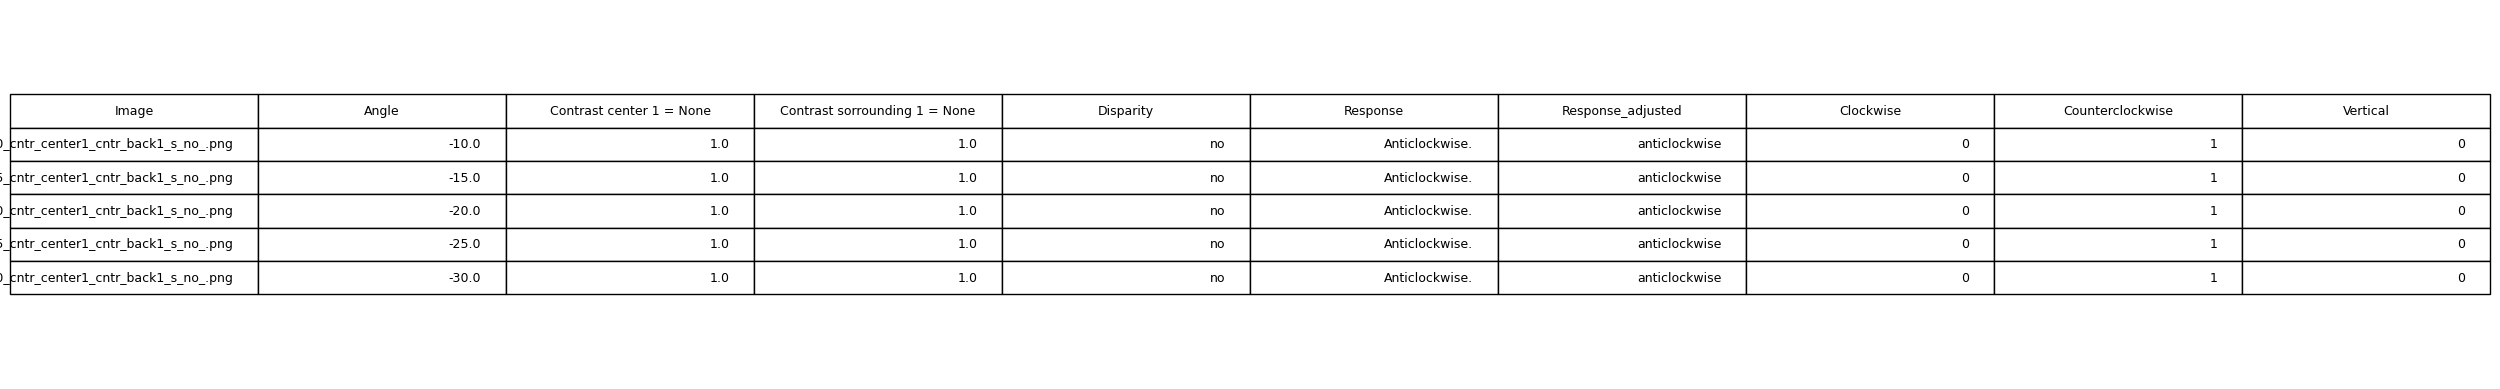

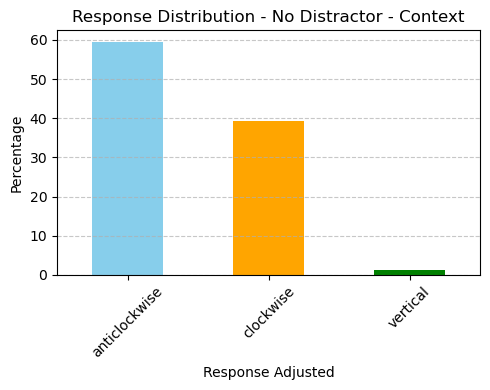

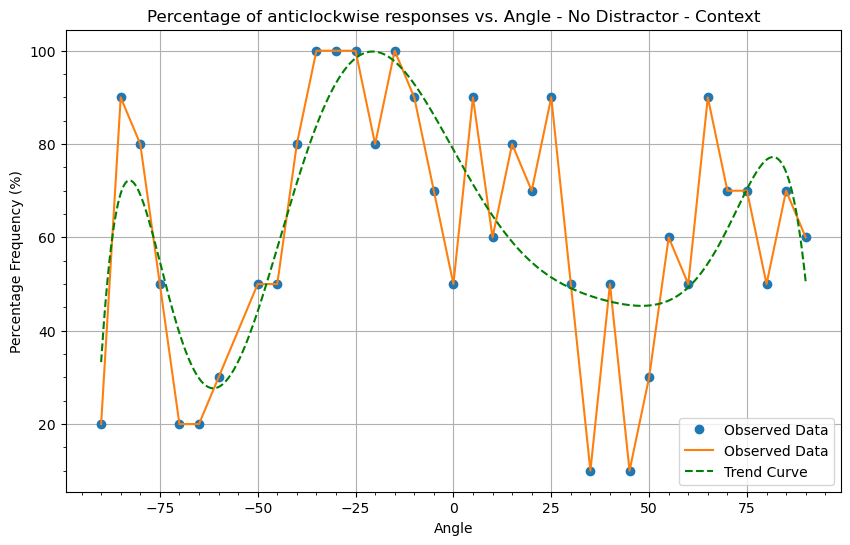

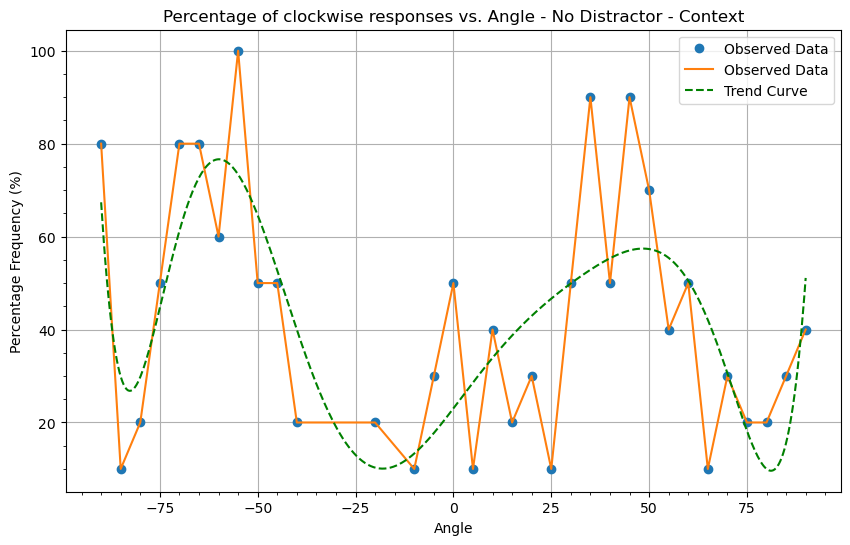

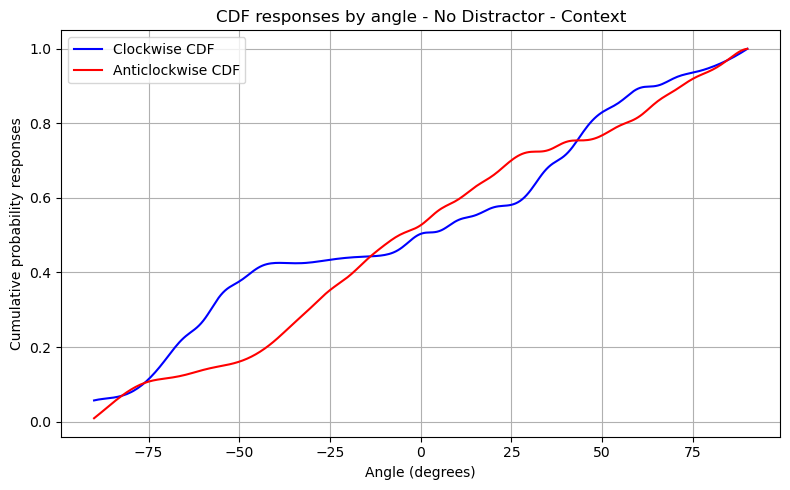

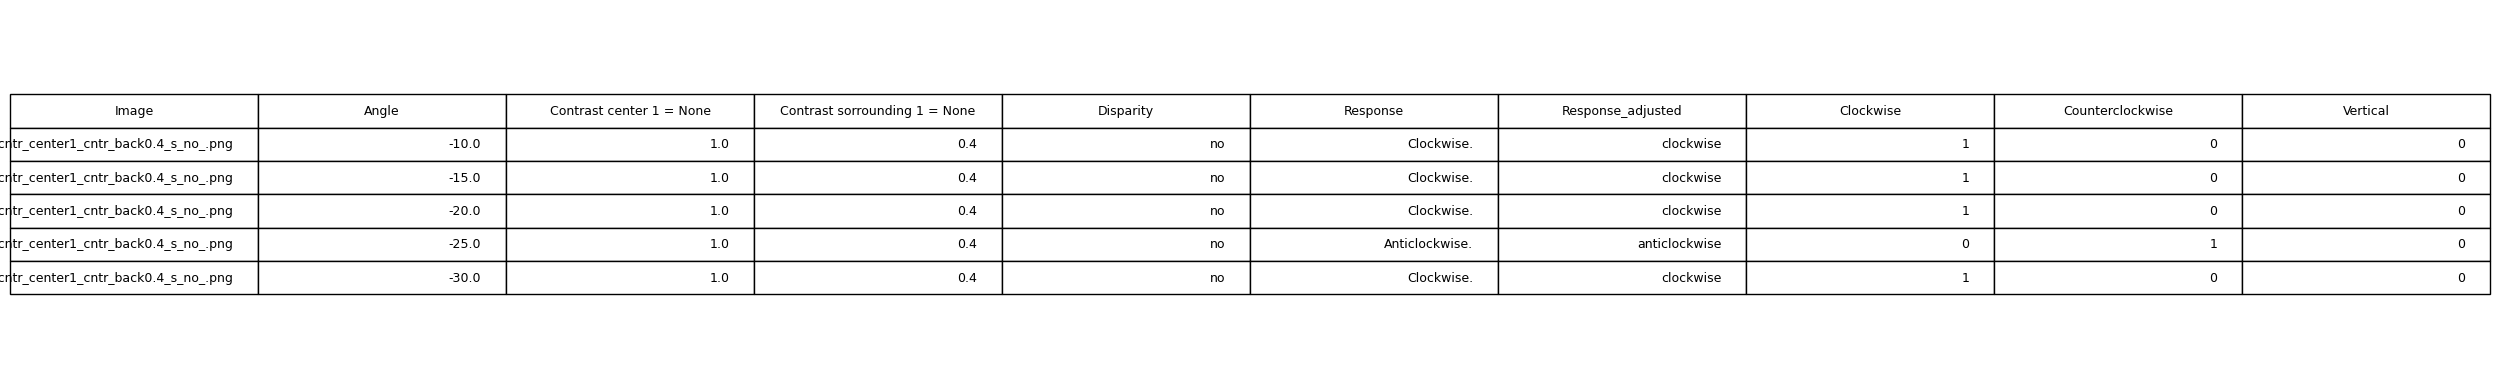

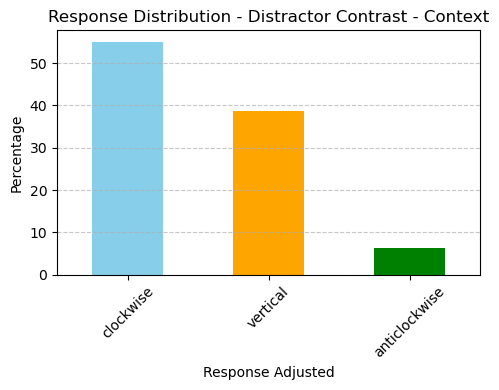

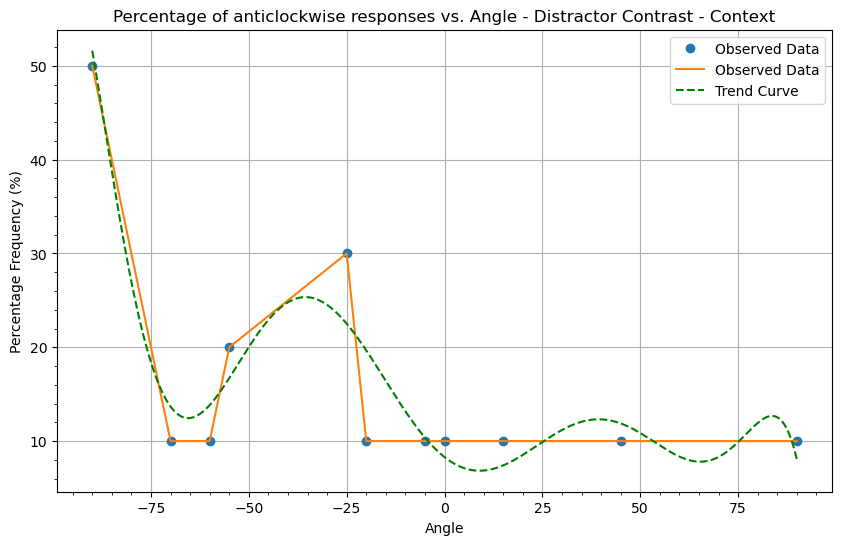

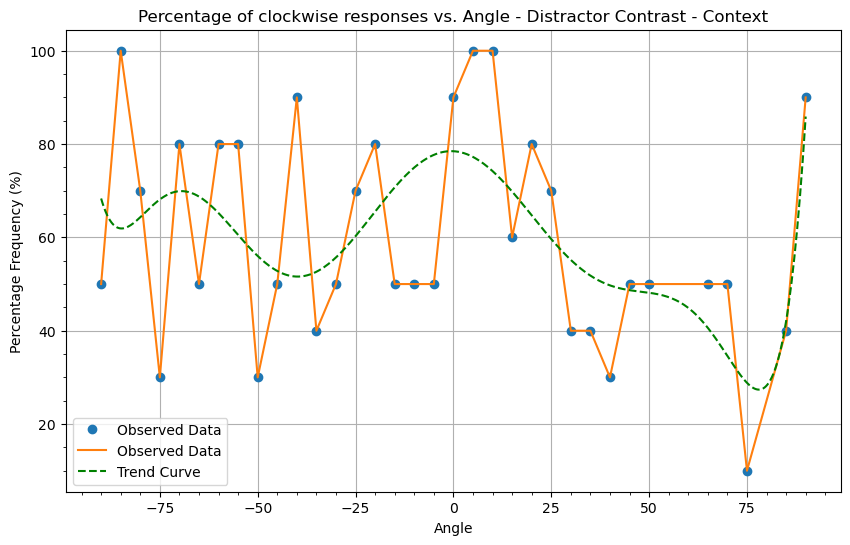

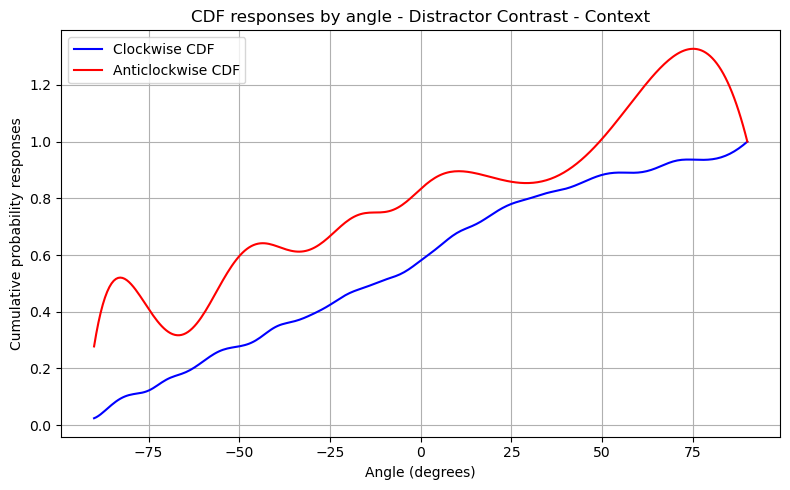

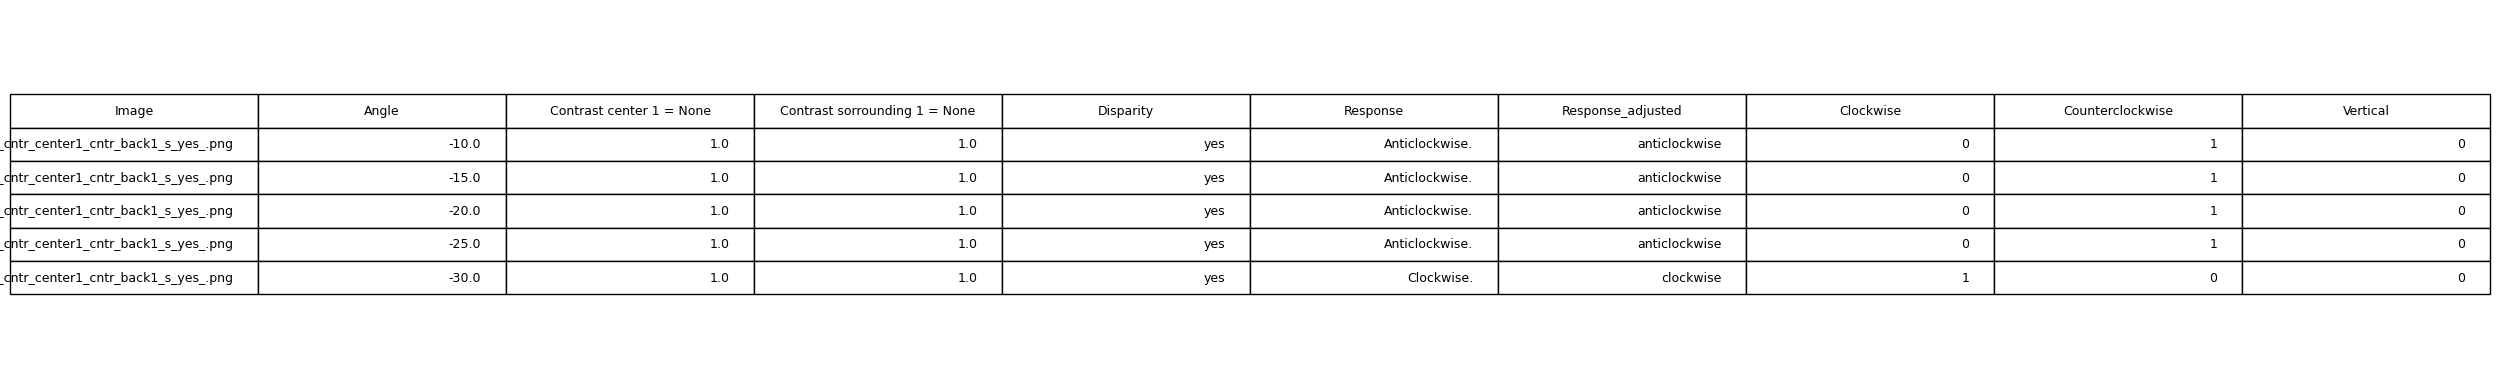

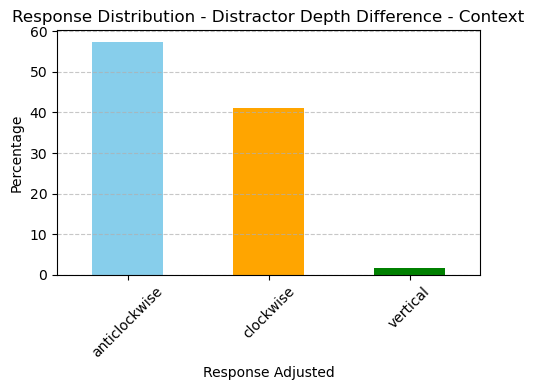

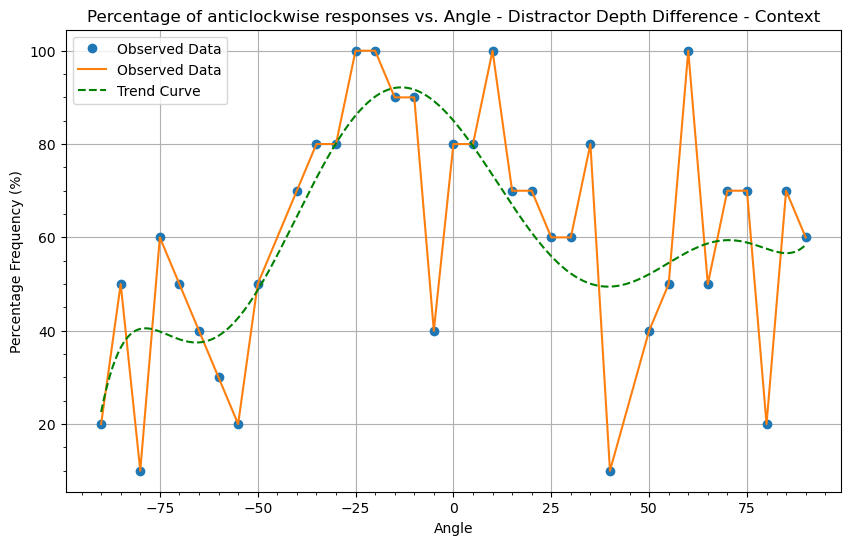

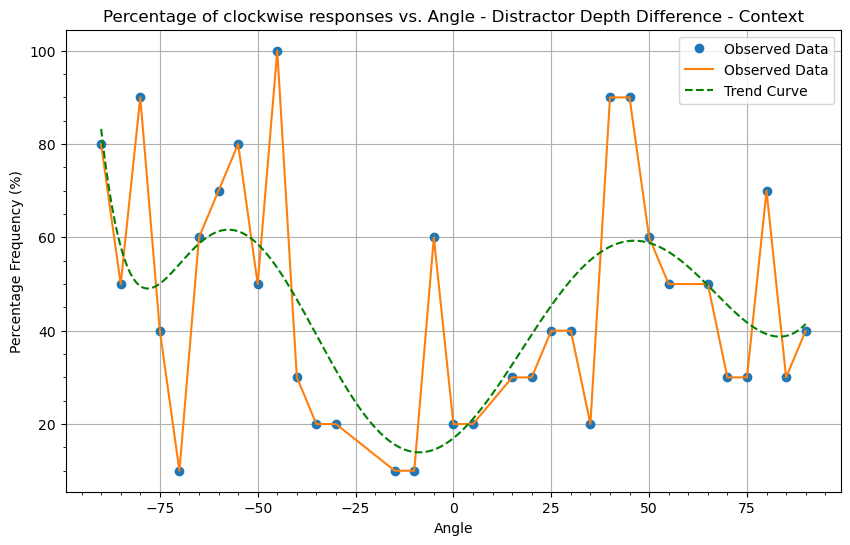

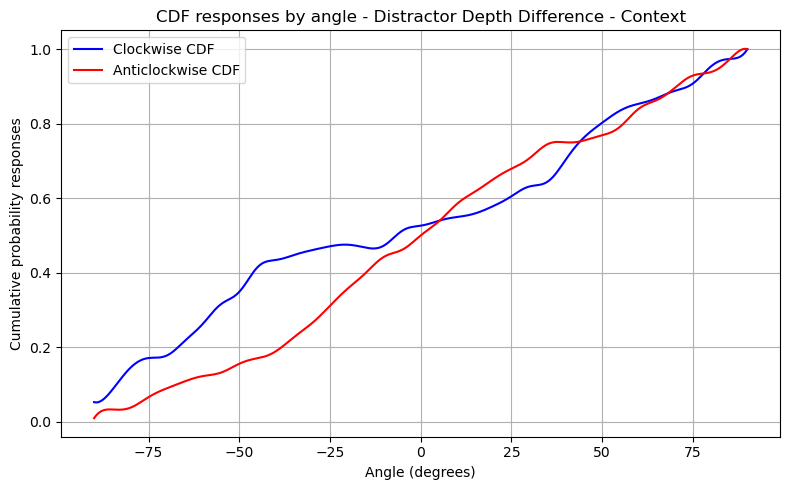

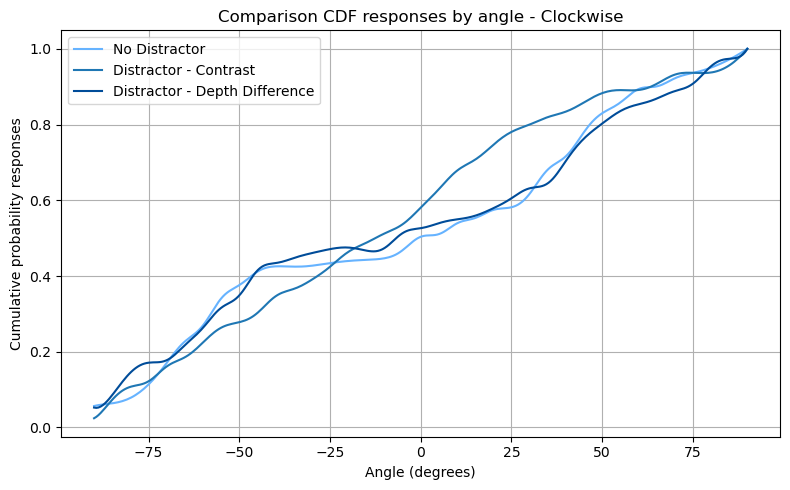

In [ ]:
data_nodistractor = read_csv(report_nodistractor_context)
plot_tables(data_nodistractor, " - No Distractor - Context")
plot_frequency_report(data_nodistractor, " - No Distractor - Context", "anticlockwise")
plot_frequency_report(data_nodistractor, " - No Distractor - Context", "clockwise")
plot_cdf(data_nodistractor, " - No Distractor - Context")


data_distractor_contrast = read_csv(report_distractor_contrast_context)
plot_tables(data_distractor_contrast, " - Distractor Contrast - Context")
plot_frequency_report(data_distractor_contrast, " - Distractor Contrast - Context", "anticlockwise")
plot_frequency_report(data_distractor_contrast, " - Distractor Contrast - Context", "clockwise")
plot_cdf(data_distractor_contrast, " - Distractor Contrast - Context")


data_distractor_depth = read_csv(report_distractor_depth_context)
plot_tables(data_distractor_depth, " - Distractor Depth Difference - Context")
plot_frequency_report(data_distractor_depth, " - Distractor Depth Difference - Context", "anticlockwise")
plot_frequency_report(data_distractor_depth, " - Distractor Depth Difference - Context", "clockwise")
plot_cdf(data_distractor_depth, " - Distractor Depth Difference - Context")

plot_cdf_consolidated(data_nodistractor, data_distractor_contrast, data_distractor_depth)